In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import zipfile
from google.colab import files
import matplotlib.pyplot as plt


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Define paths
zip_file_path = '/content/drive/MyDrive/Image-Classification-Transfer-Learning-master.zip'
extract_dir = '/content/drive/MyDrive/Image-Classification-Transfer-Learning-master'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [21]:
dataset_dir = os.path.join(extract_dir, 'Image-Classification-Transfer-Learning-master', 'Dataset')
train_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')

In [22]:
# ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1554 images belonging to 20 classes.


In [24]:
# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.jpg', '.png'))]


In [25]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

In [26]:
test_images = [preprocess_image(path) for path in test_image_paths]
test_images = tf.concat(test_images, axis=0)


In [27]:
# Build the model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(20, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 60,450,324 (230.60 MB)

 Trainable params: 60,306,580 (230.05 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [29]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=train_generator  # Use a portion of training data as validation data
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.5449 - loss: 1.7576 - val_accuracy: 0.9035 - val_loss: 0.4271
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9201 - loss: 0.2613 - val_accuracy: 0.9131 - val_loss: 0.3413
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9586 - loss: 0.1550 - val_accuracy: 0.9691 - val_loss: 0.1070
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9659 - loss: 0.1171 - val_accuracy: 0.9627 - val_loss: 0.1358
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9569 - loss: 0.1331 - val_accuracy: 0.9627 - val_loss: 0.1293
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9683 - loss: 0.1119 - val_accuracy: 0.9318 - val_loss: 0.2472
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9708 - loss: 0.1142 - val_accuracy: 0.9704 - val_loss: 0.1271
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9729 - loss: 0.1041 - val_accuracy: 0.9698 - val_loss: 0.1021
Ep

In [30]:
# Evaluate the model on training data (as test data isn't labeled)
loss, accuracy = model.evaluate(train_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 583ms/step - accuracy: 0.9765 - loss: 0.0831
Test Loss: 0.09657025337219238
Test Accuracy: 0.9749034643173218


In [31]:
# Predict on test images
predictions = model.predict(test_images)

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 902ms/step


In [32]:
# Decode predictions
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]


In [33]:
# Print predictions
for image_path, label in zip(test_image_paths, predicted_labels):
    print(f"Image: {image_path}, Predicted label: {label}")

Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_0.jpg, Predicted label: bear
Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1001.jpg, Predicted label: bear
Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1007.jpg, Predicted label: bear
Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1011.jpg, Predicted label: owl
Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1023.jpg, Predicted label: bear
Image: /content/drive/MyDrive/Image-Classification-Transfer-Learning-master/Image-Classification-Transfer-Learning-master/Dataset/test/IMG_1031.jpg, 

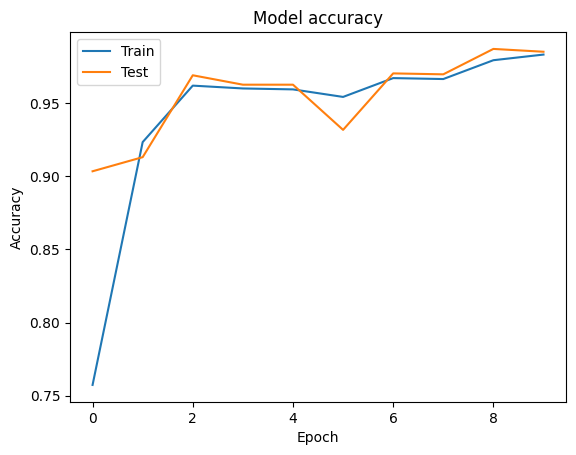

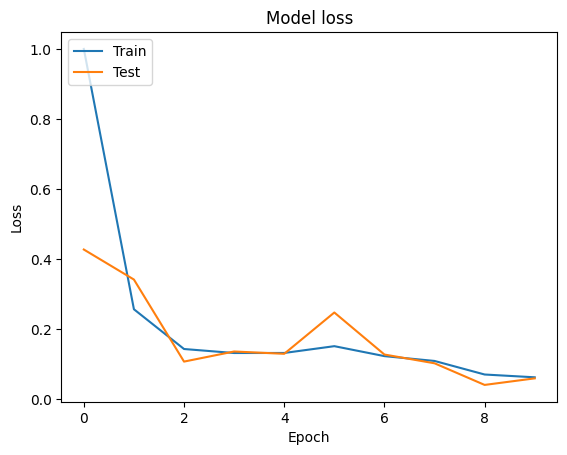

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()